In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
import pandas as pd
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [11]:
data_processed = pd.read_csv('tweets_preprocessed2.csv')
# non_suicide_data = data_processed[data_processed['class'] == 'non-suicide'].sample(n=500)
# suicide_data = data_processed[data_processed['class'] == 'suicide'].sample(n=500)
balanced_data = data_processed # pd.concat([non_suicide_data, suicide_data])

## Data Preprocessing

In [12]:
all_tokens = set(i.lower() for token in balanced_data["text"] for i in word_tokenize(token))
word_map = {token: idx for idx, token in enumerate(list(all_tokens))}
word_map['UNK'] = len(word_map)
word_map['PAD'] = len(word_map)+1

In [13]:
def text_encoder(sentence, word_map):
    tokens = word_tokenize(sentence.lower())
    encode = [word_map.get(token, word_map['UNK']) for token in tokens]
    return encode

In [14]:
class SuicideDataset(Dataset):
    def __init__(self, sentences, labels, vocab):
        self.sentences = sentences
        self.vocab = vocab
        self.label_mapping = {
            'non-suicide': 0,
            'suicide': 1
        }
        self.labels = [self.label_mapping[label] for label in labels]

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = self.sentences[item]
        label = self.labels[item]
        encoded_sentence = text_encoder(sentence, self.vocab)
        
        return {
            'input_ids': torch.tensor(encoded_sentence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }


In [15]:
# Pad the input_ids to the length of the longest sequence in the batch
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    labels = [item['label'] for item in batch]

    
    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=word_map['PAD'])
    labels = torch.stack(labels)
    text_lengths = torch.tensor([len(ids) for ids in input_ids], dtype=torch.long)
        
    return {
        'input_ids': padded_input_ids,
        'label': labels,
        'text_length': text_lengths
    }

In [16]:
# Split data
train_data, test_data, train_label, test_label = train_test_split(
    balanced_data['text'], balanced_data['class'], test_size=0.2, random_state=42
)

# Create datasets and dataloaders
train_dataset = SuicideDataset(train_data.to_numpy(), train_label.to_numpy(), word_map)
test_dataset = SuicideDataset(test_data.to_numpy(), test_label.to_numpy(), word_map)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

## Binary-Classfication LSTM

In [17]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM,self).__init__()
        self.embedding = nn.Embedding(vocab_size+1,embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers = n_layers,
                            bidirectional = bidirectional,
                            dropout = dropout,
                            batch_first = True
                           )
        self.fc = nn.Linear(hidden_dim * 2,output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid() # use sigmoid as activation function

    def forward(self,text,text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(),batch_first=True, enforce_sorted=False)
        packed_output,(hidden_state,cell_state) = self.lstm(packed_embedded)
        
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim = 1)
        hidden = self.batch_norm(hidden)
        outputs=self.sigmoid(self.fc(self.dropout(hidden)))
        
        return outputs

In [18]:
# Hyperparameters
embedding_dim = 128
hidden_dim = 256
output_dim = 2  # suicidal/non-suicidal
n_layers = 2
bidirectional = True
dropout = 0.3

In [19]:
model = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [20]:
def accuracy(preds, y):
    rounded_preds = torch.argmax(preds, dim=1)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc

In [21]:
def train(model,loader,optimizer,criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0
    
    model.train()
    
    for batch in loader:
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        labels = batch['label'].to(device)
        text_length = batch['text_length'].to(device)

        outputs = model(input_ids, text_length)
        loss = criterion(outputs, labels)
        loss.backward()
        acc = accuracy(outputs, labels)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [22]:
def evaluate(model,loader,criterion): 
    epoch_loss = 0.0
    epoch_acc = 0.0
    model.eval()

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            text_length = batch['text_length'].to(device)
            
            outputs = model(input_ids, text_length)

            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [23]:
# EPOCH_NUMBER = 10
# t_acc = []
# t_loss = []
# v_acc = []
# v_loss = []

# for epoch in range(1,EPOCH_NUMBER+1):
    
#     train_loss,train_acc = train(model,train_loader,optimizer,criterion)
    
#     valid_loss,valid_acc = evaluate(model,test_loader,criterion)
    
#     t_acc.append(train_acc)
#     t_loss.append(train_loss)
#     v_acc.append(valid_acc)
#     v_loss.append(valid_loss)
    
#     print("Epoch", epoch)
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
#     print()

In [24]:
# print("The best validation accuracy:", round(max(v_acc), 2))

In [25]:
# plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
# plt.title("Accuracy")
# plt.legend(("Training", "Validation"))

In [26]:
# plt.plot(range(1, EPOCH_NUMBER+1), t_loss, v_loss)
# plt.title("Loss")
# plt.legend(("Training", "Validation"))

# GridSearch for Binary Classification LSTM

In [31]:
from itertools import product
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import numpy as np
import torch
from torch.utils.data import DataLoader

# Define the grid of hyperparameters
param_grid = {
    'embedding_dim': [64, 128, 256],
    'hidden_dim': [128, 256, 512],
    'n_layers': [1, 2, 3],
    'dropout': [0.2, 0.3, 0.5],
    'learning_rate': [0.001, 0.0005, 0.0001]
}


In [28]:
# Define train_and_evaluate with updated metrics
def train_and_evaluate(params, train_loader, val_loader):
    embedding_dim, hidden_dim, n_layers, dropout, learning_rate = params

    # Initialize model
    model = LSTM(
        vocab_size=len(word_map),
        embedding_dim=embedding_dim,
        hidden_dim=hidden_dim,
        output_dim=2,
        n_layers=n_layers,
        bidirectional=True,
        dropout=dropout
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_valid_metrics = {'accuracy': 0, 'roc_auc': 0, 'confusion_matrix': None}

    for epoch in range(1, EPOCH_NUMBER + 1):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion)
        valid_metrics = evaluate(model, val_loader, criterion)

        # Keep track of best validation metrics
        if valid_metrics['accuracy'] > best_valid_metrics['accuracy']:
            best_valid_metrics = valid_metrics

    return best_valid_metrics

In [29]:
# Evaluation function for metrics
def evaluate(model, loader, criterion):
    model.eval()
    all_labels, all_preds, all_probs = [], [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            text_length = batch['text_length'].to(device)

            outputs = model(input_ids, text_length)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_probs.extend(outputs[:, 1].cpu().numpy())

    # Metrics calculation
    accuracy = accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)

    return {'accuracy': accuracy, 'roc_auc': roc_auc, 'confusion_matrix': cm}

In [ ]:
# Modified to ignore Dropout for n_layers=1

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size+1, embedding_dim)
        
        # Automatically disable dropout for single-layer LSTM
        dropout = 0.0 if n_layers == 1 else dropout

        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.batch_norm = nn.BatchNorm1d(hidden_dim * 2 if bidirectional else hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function for binary classification

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)
        
        hidden = torch.cat((hidden_state[-2,:,:], hidden_state[-1,:,:]), dim=1) if self.lstm.bidirectional else hidden_state[-1,:,:]
        hidden = self.batch_norm(hidden)
        outputs = self.sigmoid(self.fc(self.dropout(hidden)))
        
        return outputs


In [ ]:
# Grid search implementation
results = []
EPOCH_NUMBER = 10
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over all hyperparameter combinations
for params in product(*param_grid.values()):
    avg_accuracy, avg_roc_auc = [], []
    avg_confusion_matrix = np.zeros((2, 2))

    # Cross-validation
    for train_idx, val_idx in kf.split(balanced_data):
        train_data_split = balanced_data.iloc[train_idx]
        val_data_split = balanced_data.iloc[val_idx]

        # Create datasets and dataloaders
        train_dataset = SuicideDataset(train_data_split['text'].to_numpy(),
                                       train_data_split['class'].to_numpy(),
                                       word_map)
        val_dataset = SuicideDataset(val_data_split['text'].to_numpy(),
                                     val_data_split['class'].to_numpy(),
                                     word_map)

        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

        # Train and evaluate
        metrics = train_and_evaluate(params, train_loader, val_loader)
        avg_accuracy.append(metrics['accuracy'])
        avg_roc_auc.append(metrics['roc_auc'])
        avg_confusion_matrix += metrics['confusion_matrix']

    # Average metrics across folds
    avg_accuracy = np.mean(avg_accuracy)
    avg_roc_auc = np.mean(avg_roc_auc)
    avg_confusion_matrix /= kf.get_n_splits()

    results.append((params, avg_accuracy, avg_roc_auc, avg_confusion_matrix))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


In [ ]:
# Find the best parameters
best_params, best_accuracy, best_roc_auc, best_cm = max(results, key=lambda x: x[1])
print("Best Parameters:", best_params)
print(f"Best Validation Accuracy: {best_accuracy:.4f}")
print(f"Best Validation ROC AUC: {best_roc_auc:.4f}")
print("Best Confusion Matrix:\n", best_cm)

## Regression LSTM

In [16]:
# # Hyperparameters
# embedding_dim = 128
# hidden_dim = 256
# output_dim = 1  # probability
# n_layers = 2
# bidirectional = True
# dropout = 0.3

In [17]:
# regression = LSTM(len(word_map), embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(regression.parameters(), lr=0.001)

# # Training loop
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# regression = regression.to(device)

In [18]:
# def re_accuracy(preds, y, threshold=0.5):
#     rounded_preds = (preds > threshold).float()  # Convert probabilities to binary predictions
#     correct = (rounded_preds == y).float()
#     acc = correct.sum() / len(correct)
#     return acc

In [19]:
# def re_train(model,loader,optimizer,criterion):
#     epoch_loss = 0.0
#     epoch_acc = 0.0
    
#     model.train()
    
#     for batch in loader:
#         optimizer.zero_grad()
        
#         input_ids = batch['input_ids'].to(device)
#         labels = batch['label'].float().to(device)
#         text_length = batch['text_length'].to(device)

#         outputs = model(input_ids, text_length).squeeze(1)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         acc = re_accuracy(outputs, labels)
#         optimizer.step()
        
#         epoch_loss += loss.item()
#         epoch_acc += acc.item()

#     return epoch_loss / len(loader), epoch_acc / len(loader)

In [20]:
# def re_evaluate(model,loader,criterion): 
#     epoch_loss = 0.0
#     epoch_acc = 0.0
#     model.eval()

#     with torch.no_grad():
#         for batch in loader:
#             input_ids = batch['input_ids'].to(device)
#             labels = batch['label'].float().to(device)
#             text_length = batch['text_length'].to(device)
            
#             outputs = model(input_ids, text_length).squeeze(1)

#             loss = criterion(outputs, labels)
#             acc = re_accuracy(outputs, labels)
            
#             epoch_loss += loss.item()
#             epoch_acc += acc.item()
        
#     return epoch_loss / len(loader), epoch_acc / len(loader)

In [22]:
# EPOCH_NUMBER = 10
# t_acc = []
# t_loss = []
# v_acc = []
# v_loss = []

# for epoch in range(1,EPOCH_NUMBER+1):
    
#     train_loss,train_acc = re_train(regression,train_loader,optimizer,criterion)
    
#     valid_loss,valid_acc = re_evaluate(regression,test_loader,criterion)
    
#     t_acc.append(train_acc)
#     t_loss.append(train_loss)
#     v_acc.append(valid_acc)
#     v_loss.append(valid_loss)
    
#     print("Epoch", epoch)
#     print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
#     print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
#     print()

Epoch 1
	Train Loss: 0.671 | Train Acc: 66.88%
	 Val. Loss: 0.528 |  Val. Acc: 71.63%

Epoch 2
	Train Loss: 0.355 | Train Acc: 85.12%
	 Val. Loss: 0.849 |  Val. Acc: 59.62%

Epoch 3
	Train Loss: 0.254 | Train Acc: 89.38%
	 Val. Loss: 0.846 |  Val. Acc: 72.60%

Epoch 4
	Train Loss: 0.139 | Train Acc: 95.12%
	 Val. Loss: 0.861 |  Val. Acc: 69.23%

Epoch 5
	Train Loss: 0.107 | Train Acc: 96.25%
	 Val. Loss: 1.493 |  Val. Acc: 58.17%

Epoch 6
	Train Loss: 0.096 | Train Acc: 96.50%
	 Val. Loss: 0.826 |  Val. Acc: 74.52%

Epoch 7
	Train Loss: 0.062 | Train Acc: 98.12%
	 Val. Loss: 0.766 |  Val. Acc: 76.92%

Epoch 8
	Train Loss: 0.034 | Train Acc: 98.88%
	 Val. Loss: 0.832 |  Val. Acc: 76.92%

Epoch 9
	Train Loss: 0.028 | Train Acc: 99.00%
	 Val. Loss: 0.941 |  Val. Acc: 75.00%

Epoch 10
	Train Loss: 0.059 | Train Acc: 98.00%
	 Val. Loss: 0.959 |  Val. Acc: 76.44%



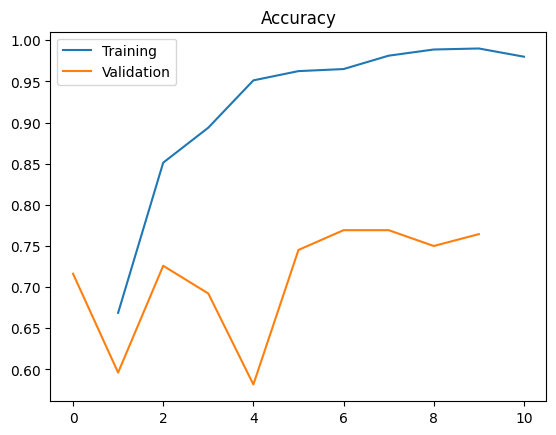

In [23]:
# plt.plot(range(1, EPOCH_NUMBER+1), t_acc, v_acc)
# plt.title("Accuracy")
# plt.legend(("Training", "Validation"))

## Inference

### Binary Classfication

In [488]:
# def predict_sentence(sentence, model, word_map, device):
#     # Preprocess the sentence
#     encoded_sentence = text_encoder(sentence, word_map)
#     input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)  # Add batch dimension

#     # Get the length of the input sentence (for packing sequence)
#     text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

#     # Perform inference
#     model.eval()  # Set the model to evaluation mode
#     with torch.no_grad():
#         output = model(input_tensor, text_length)  # Get the model output
#         prediction = torch.argmax(output, dim=1).item()  # Get the predicted class (0 or 1)

#     # Interpret the result
#     if prediction == 0:
#         return "The sentence is classified as Non-Suicidal."
#     else:
#         return "The sentence is classified as Suicidal."

In [489]:
# sentence = "I feel hopeless."
# result = predict_sentence(sentence, model, word_map, device)
# print(result)

The sentence is classified as Suicidal.


### Regression

In [24]:
# def regression_predict(sentence, model, word_map, device):

#     encoded_sentence = text_encoder(sentence, word_map)
#     input_tensor = torch.tensor(encoded_sentence, dtype=torch.long).unsqueeze(0).to(device)

#     text_length = torch.tensor([len(encoded_sentence)], dtype=torch.long).to(device)

#     model.eval()
#     with torch.no_grad():
#         output = model(input_tensor, text_length)  # Get the model output
#         probability = torch.sigmoid(output).squeeze().item()  # Get the probability

#     prediction = 1 if probability >= 0.5 else 0  # Threshold of 0.5
#     if prediction == 0:
#         result = f"The sentence is classified as Non-Suicidal with a probability of {1 - probability:.4f}."
#     else:
#         result = f"The sentence is classified as Suicidal with a probability of {probability:.4f}."

#     return result

In [26]:
# sentence = "I feel sad."
# result = regression_predict(sentence, regression, word_map, device)
# print(result)

The sentence is classified as Suicidal with a probability of 0.6399.
